# 1. Load Libararies and Prepare the dataset for Sentiment Analysis 

** Load Python Liberaries **

In [1]:
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import seaborn as sns
import numpy as np
import re
import csv
import pandas as pd
import operator
%matplotlib inline
import tweepy
from textblob import TextBlob
from afinn import Afinn
afinn = Afinn()

In [2]:
consumer_key=''
consumer_secret=''
access_token=''
access_token_secret=''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

** 1.1 Load data and crate additional column for extracted features ** 

In [3]:
df = pd.read_csv("sports_tweet_final.csv",encoding='latin-1')

In [4]:
df['team']=""

In [5]:
df['player']=""

** 1.2 Drop the duplicates if any **

In [6]:
df.shape

(27750, 5)

In [7]:
df.head()

,timestamp,tweet,source,team,player
0,11/8/2018 23:48,b'RT @PatelTejesh: Desperately waiting for sem...,Twitter Web Client,,
1,11/8/2018 22:47,b'India-West Indies ODI Series \xe2\x80\x93 3r...,Tweet Old Post,,
2,11/8/2018 22:08,b'@imVkohli \nI think ur immature and Impulsiv...,Twitter for Android,,
3,11/8/2018 21:43,b'STOP SUPPORTING @BCCI TEAM!!! MAKE THEM TO L...,Twitter for Android,,
4,11/8/2018 21:10,b'RT @umeshkshakya: Watching #INDVsWI 2nd T20 ...,Twitter for Android,,


** 1.3 Functions to clean the data & generate labels the dataframe **

In [8]:
 players = {'Rohit': 'Rohit,imRo45,Rohit Sharma' , 'Shikhar':'SDhawan25,dhawan,Shikhar','Rahul':'KL Rahul,Rahul,klrahul11'
 ,'Dinesh':'DK,Dinesh,Karthik,DineshKarthik', 'Manish':'Manish,Pandey,im_manishpandey','Shreyas':'Shreyas,Iyer', 'Rishabh':'Rishabh,Pant,Rishabhpanth'
 ,'Krunal':'krunal,krunalpandya24' ,'washington':'washington,sundar','bhuveneshwar':'bhuvi,bhuveneshwar','Chahal':'chahal,yuzi,Yuzevendra,yuzi_chahal'
 ,'Kuldeep':'kuldeep,mkuldeep18' , 'Bumrah':'Bumrah,Jaspritbumrah93' , 'Khaleel':'Khaleel,Ahmed','Umesh':'Umesh,y_umesh','Ajinkya':'Rahane,Ajinkya,ajinkyarahane88'
 ,'Dhoni':'msdhoni,dhoni','Virat': 'imVkohli,kohli,virat', 'Hardik':'hardik,hardikpandya7'
 ,'Carlos':'brathwaite88,Carlos','Fabian':'Fabian','Darren':'DMBravo46,Darren','Shimron':'Shetmyer,Shimron'
 ,'Evin':'Evin17Lewis,Evin','Obed':'Obed','Ashley':'AshleyNurse,Ashley','Keemo':'Keemo'
 ,'Khary':'Khary','Kieron':'KieronPollard55,Kieron','Rovman':'Rovman','Denesh':'Denesh','Andre':'Russell12A,Andre','Sherfane':'Sherfane'
 ,'Oshane':'Oshane'}
    
''' Clean the tweets '''

def clean_tweets(tweet):
    url = re.compile('https\S+')
    urls = url.sub('',tweet)
    user = re.compile('@\w+')
    users = user.sub('',urls)
    mention = re.compile('#\w+')
    mentions = (mention.sub('',users))
    apo = re.compile('^b\'RT')
    apos = apo.sub('',mentions)
    apo2 = re.compile('^b\'')
    tweet = apo2.sub('',apos)
    punc_pat = re.compile('[^\?\!\w\s]')
    punc = punc_pat.sub('',tweet)
    clean_tweet = punc.lower()
    return clean_tweet

''' Assign Polarity class based on polarity score of TextBlob method '''

def class_polarity(tweet):
    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0: 
            return 'positive'
    elif analysis.sentiment.polarity < 0: 
            return 'negative'
    else: 
            return 'neutral'

''' Assign Polarity class based on pscore of Affin method '''  

def class_pscore(tweet):
    pscore = afinn.score(tweet)
    if pscore > 0: 
            return 'positive'
    elif pscore < 0: 
            return 'negative'
    else: 
            return 'neutral'
    
'''Calculates polarity of given document - TextBlob'''

def calc_polarity(tweet):
    #Step 4 Perform Sentiment Analysis on Tweets
    analysis = TextBlob(tweet)
    return analysis.sentiment.polarity

'''Calculates pscore of given document - Afinn'''

def calc_pscore(tweet):
    #Step 4 Perform Sentiment Analysis on Tweets
    pscore = afinn.score(tweet)
    return pscore

'''Extract and generate Player Label'''

def get_player_label_weight(tweet):
    nameCountDict = {}
    for k, v in players.items():    
        names = v.split(',')
        nameCount = 0
        for name in names:
            nameCount = nameCount + tweet.count(name.lower())
        nameCountDict[k] = nameCount
    #print(nameCountDict)
    #print(max(nameCountDict.values()))
    if max(nameCountDict.values()) != 0:
        return max(nameCountDict.items(), key=operator.itemgetter(1))[0]
    else:
        return -1
'''Extract and generate Team Label'''

def get_team_label_weight(tweet):
        indCount = tweet.count("india")
        westIndCount = tweet.count("west indies")
        #print("india,westind", indCount, westIndCount)
        if indCount > westIndCount:
            return 1
        elif westIndCount > indCount:
            return 0
        else:
            return 2
        

** 1.4 Update the dataframe with Labels such as Team,Player, Polarity and Polarity class (Postive,Negative,Neutral) **

In [9]:
for i,row in df.iterrows():
    clean_tweet = clean_tweets(row['tweet'])
    df.at[i,'tweet'] = clean_tweet
    team_label = get_team_label_weight(clean_tweet)
    df.at[i,'team'] = team_label
    player_label = get_player_label_weight(clean_tweet)
    df.at[i,'player'] = player_label
    polclass = class_polarity(clean_tweet)
    df.at[i,'polarity_class']=polclass
    polarity = calc_polarity(clean_tweet)
    df.at[i,'polarity']=polarity

In [10]:
''' Parse day column from time stamp to see sentiment flow over days '''
df['day'] = pd.to_datetime(df['timestamp']).dt.day

In [11]:
''' Mapping team names '''

teams = {0:'WI',1:'IND',2:'Neither'}
df['team'] = df['team'].map(teams)

# 2. sentiment Analysis using Texblog and Afinn Lexicon based approach

** 2.1 Using Texblob Polarity Score and Classes **

** 2.1.1 Top 10 Tweeted Players Sentiment Classification **

Text(0.5,1,'Top Twitted Players')

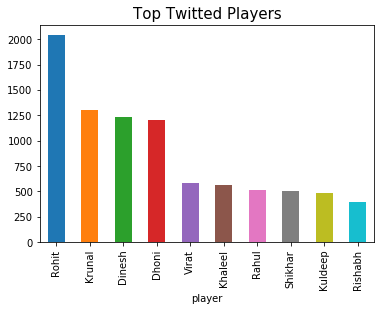

In [12]:
df[ df['player'] != -1].groupby('player').polarity.count().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top Twitted Players',fontsize=15)

In [13]:
top_10 = df[ df['player'] != -1].groupby('player').polarity.count().sort_values(ascending=False).head(10)

In [14]:
top_10= list(top_10.index)

In [15]:
res  =df[(df['player'].isin(top_10) & (df['polarity_class']!= 'neutral'))].groupby(['player', 'polarity_class'])['polarity'].mean().sort_values(ascending=False).reset_index()

Text(0.5,1,'Top Twitted Player Sentiment Score')

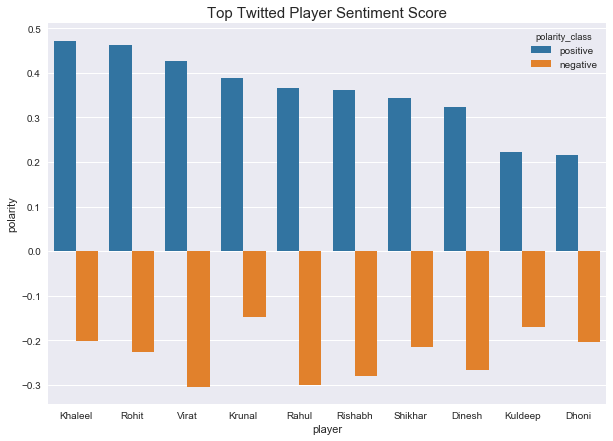

In [16]:
import seaborn as sns
sns.set(rc={'figure.figsize':(10,7)})
sns.set(style="darkgrid")
ax = sns.barplot(x="player", y="polarity",hue="polarity_class",data=res,palette='tab10')
plt.title("Top Twitted Player Sentiment Score",fontsize=15)

** 2.1.2 Team level sentiment Classification **

Text(0.5,1,'Day wise count plot of tweets count')

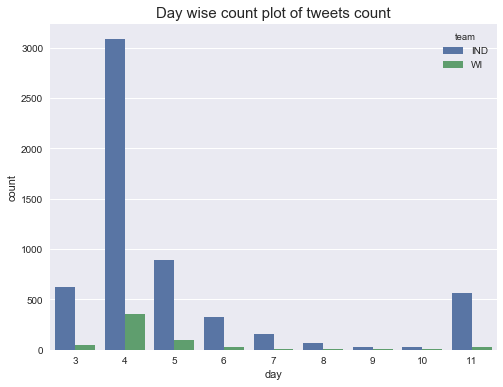

In [17]:
''' Day wise count plot of tweets '''
plt.figure(figsize=(8,6))
sns.countplot(x='day',hue='team',data=df[df['team']!='Neither'])
plt.title('Day wise count plot of tweets count',fontsize=15)

Text(0.5,1,'Positive / Negative Classification for India and West Indies')

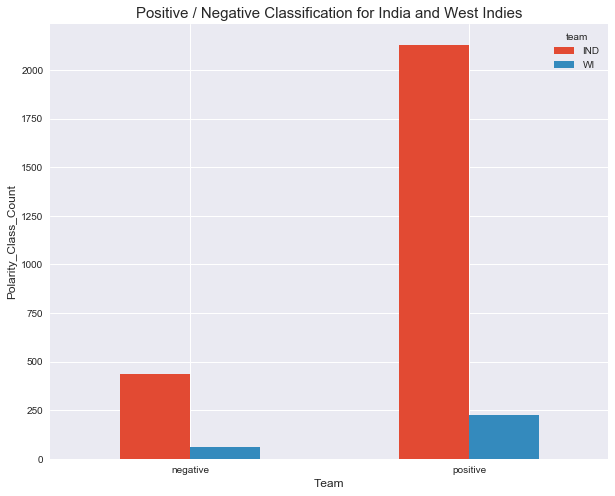

In [18]:
fig, ax = plt.subplots(figsize=(10,8))
plt.style.use('ggplot')
df[(df['team'] !='Neither') & (df['polarity_class']!='neutral')].groupby('polarity_class').team.value_counts().unstack().plot(ax=ax,kind='bar')
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(labels,rotation=360)
ax.set_xlabel('Team' , fontsize=12)
ax.set_ylabel('Polarity_Class_Count', fontsize='12') 
plt.title('Positive / Negative Classification for India and West Indies',fontsize=15)

In [19]:
''' % of tweets per Team'''

pos_tweet=[]
neg_tweet=[]
tweets = len(df)
for i,row in df.iterrows():
    if row['polarity_class'] == 'positive':
        pos_tweet.append(row['tweet'])
    elif row['polarity_class'] == 'negative':
        neg_tweet.append(row['tweet'])
print("Percentage tweets for teams")
print(str('-')*50)
print("Positive tweets percentage: {} %".format(100*len(pos_tweet)/(tweets))) 
print("Negative tweets percentage: {} %".format(100*len(neg_tweet)/(tweets)))

Percentage tweets for teams
--------------------------------------------------
Positive tweets percentage: 39.88828828828829 %
Negative tweets percentage: 8.688288288288287 %


Text(0.5,1,'KDE plot polarity except neutral score')

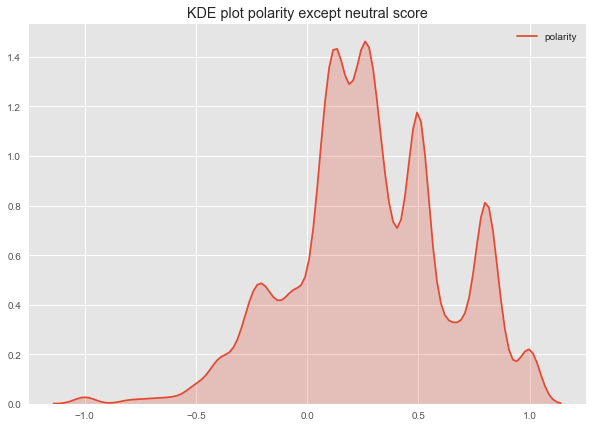

In [20]:
df_p =df[df['polarity'] != 0]
sns.kdeplot(df_p['polarity'],shade=True)
plt.title('KDE plot polarity except neutral score')

In [21]:
df_source = df[(df['source']=='Twitter for Android') | (df['source'] == 'Twitter Web Client') | (df['source'] == 'Twitter for iPhone')]

In [22]:
type(df_source)

pandas.core.frame.DataFrame

Text(0.5,1,'Day wise aggregated polarity scores')

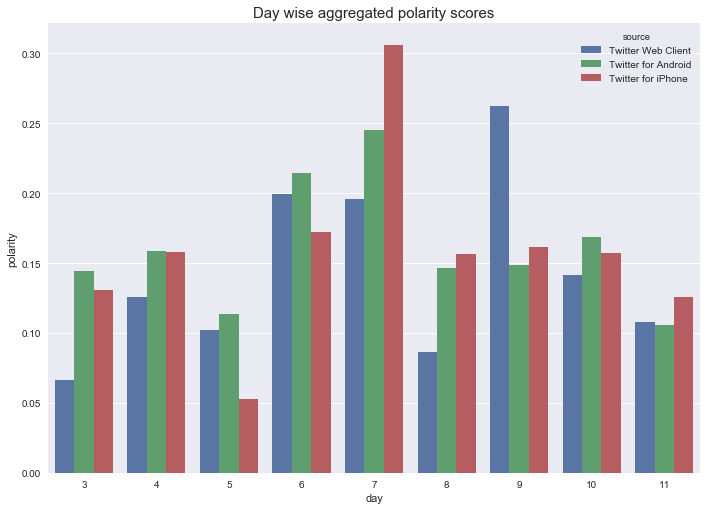

In [23]:
#n_df = df[(df['polarity_class'] != 'neutral') & (df['team']!='Neither') ]
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="darkgrid")
ax = sns.barplot(x='day',y='polarity',hue='source',data=df_source,ci=None)
plt.title('Day wise aggregated polarity scores',fontsize=15)

In [24]:
''' Optionally save it csv '''
df.to_csv("post_sentiment.csv")

** 2.2 Using Affin pscore **

In [25]:
''' Load the Affin Library '''

from afinn import Afinn
afinn = Afinn()

In [26]:
'''Create pscore '''
df['pscore'] = ""
for k,row in df.iterrows():
    clean_tweet = clean_tweets(row['tweet'])
    pscore = afinn.score(clean_tweet)
    df.at[k,'pscore'] = pscore
    pscore_class = class_pscore(clean_tweet)
    df.at[k,'pscore_class'] = pscore_class

In [27]:
df.pscore = df.pscore.astype(float)

In [28]:
''' Create datafram that without the neutral score just to remove the bias in stats visualization towards 0 values'''

df_ps = df[(df['polarity'] !=0) & (df['pscore'] !=0)]

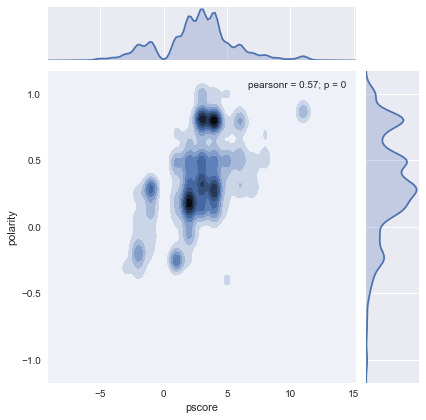

In [29]:
''' The joint plot with distribution and pearson correlation '''

sns.jointplot(x='pscore',y='polarity', data=df_ps, kind='kde')

In [30]:
''' Create datafram for India '''

India = df[df['team']=='IND']

In [31]:
'''Create dataframe for West Indies '''

WI = df[df['team']=='WI']

In [32]:
print("India, LOWEST POLARITY") 
print("-"*50)
India = India.sort_values(by='pscore')
for index, row in India.head(2).iterrows():
    print((row['tweet'], row['pscore']))
    print("*"*50)
print("-"*50)

India, LOWEST POLARITY
--------------------------------------------------
('motherfucker manish pandey what the hell is he doing in indian cricket team   ', -9.0)
**************************************************
('westindies tour of indiantests  lost by 20nodi  lost by 31nt20  lost by 20  ', -9.0)
**************************************************
--------------------------------------------------


In [33]:
print("India, Highest POLARITY")
print("-"*50)
India = India.sort_values(by='pscore')
for index, row in India.tail(2).iterrows():
    print((row['tweet'], row['pscore']))
    print("*"*50)
print("-"*50)

India, Highest POLARITY
--------------------------------------------------
('  congratulations to entire team india xf0x9fx91x8d wonderful grand victoryxe2x9cx8cnseriously  regularly proved him as a wonderful captaixe2x80xa6', 13.0)
**************************************************
(' wanted aus to win the game bt sa won it  wanted wi to win but india won it then  womenxe2x80xa6 ', 14.0)
**************************************************
--------------------------------------------------


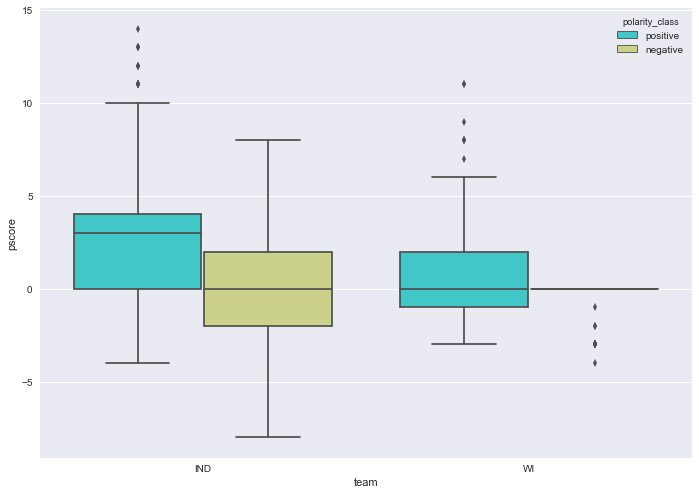

In [34]:
''' Box plot of Pscores over series Days '''

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(x="team", y="pscore", data=df[(df['polarity_class'] != 'neutral') & (df['team']!='Neither')],hue='polarity_class',palette='rainbow')

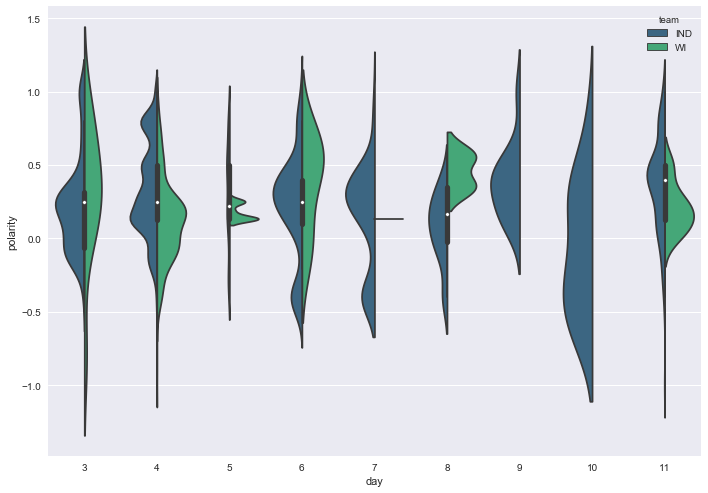

In [35]:
'''Violin Plot of pscore over Days '''
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.violinplot(x="day", y="polarity",data=df[(df['polarity_class'] != 'neutral') & (df['team']!='Neither')],hue='team',ci=None,split=True,palette='viridis')

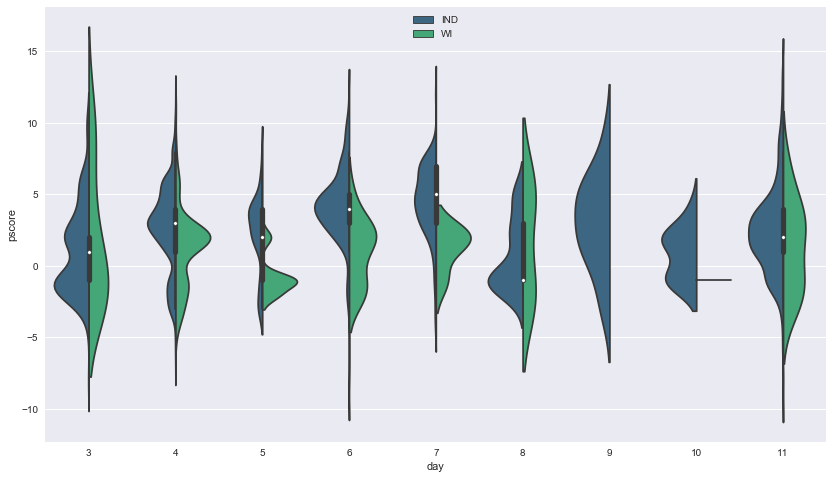

In [36]:
'''Violin Plot of pscore over Days '''
sns.set(rc={'figure.figsize':(14,8)})
sns.violinplot(x="day", y="pscore",data=df[(df['pscore_class'] != 'neutral') & (df['team']!='Neither')],hue='team',ci=None,split=True,palette='viridis',showbox=False)
plt.legend(loc='upper center')

# 3. Machine Learning Based Classification

** 3.1 preprocess the data **

In [37]:
df2 = df.copy()

In [38]:
df2 = df2[df2['polarity_class'] !='neutral']

In [39]:
df2.loc[df2['polarity_class'] == 'negative', 'polarity_class'] = 0
df2.loc[df2['polarity_class'] == 'positive', 'polarity_class'] = 1

In [40]:
df2['processed_tweets']=""

In [41]:
for i,row in df2.iterrows():
    clean_tweet = clean_tweets(row['tweet'])
    df2.at[i,'process_tweet'] = clean_tweet

In [42]:
df2['polarity_class'] = df2.polarity_class.astype('int')

In [43]:
'''Make Copy of existing dataframe and extract only required columns(features)'''
train_data = df2[['polarity_class','process_tweet']]

** 3.2 Random Forest Implementation **

In [44]:
''' Import the neceessary sklearn libraries '''

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import cross_val_score

In [45]:
''' Inititate the count and tfidf vectorizer objects '''


count_vect = CountVectorizer(stop_words='english',lowercase=True,min_df=.01, max_df=.50)
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)

In [46]:
''' train test and split the data'''

x_train, x_test, y_train, y_test = train_test_split(train_data["process_tweet"],train_data["polarity_class"], test_size = 0.2, random_state = 3)

In [47]:
''' Vectorize the train and test data so that it can be passed to machine learning models '''

x_train_counts = count_vect.fit_transform(x_train)
x_train_tfidf = transformer.fit_transform(x_train_counts)
x_test_counts = count_vect.transform(x_test)
x_test_tfidf = transformer.transform(x_test_counts)

In [48]:
'''Instanciate classifier'''
model = RandomForestClassifier(n_estimators=200)

In [49]:
cross_score_rf = cross_val_score(model,x_train_tfidf,y_train,scoring="accuracy", cv=5)
print(cross_score_rf)

[0.93373494 0.92953176 0.93324061 0.92810761 0.92532468]


In [50]:
print(np.mean(cross_score_rf))

0.9299879181587617


In [51]:
''' Fit the model '''


model.fit(x_train_tfidf,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [52]:
'''Print Predictions and Accuracy '''

predictions = model.predict(x_test_tfidf)
rf_acc = (accuracy_score(y_test,predictions))

In [53]:
print(predictions)

[1 1 1 ... 1 1 1]


In [54]:
print("The approximate accuracy of the LR Model: %d" % round((rf_acc*100),3)+str("%"))

The approximate accuracy of the LR Model: 93%


** 3.3 Logistic Regression ** 

In [55]:
''' Import the neceessary sklearn libraries '''

from  sklearn.feature_extraction.text import TfidfVectorizer
vectorizer =TfidfVectorizer(lowercase=True, stop_words='english',min_df=.01, max_df=.50)
from sklearn.linear_model import LogisticRegression


''' Vectorize data it can be passed to machine learning models '''

X=vectorizer.fit_transform(train_data["process_tweet"])
print(X.shape)

y=train_data["polarity_class"]
print(y.shape)

(13480, 166)
(13480,)


In [56]:
''' train test and split the data'''

XLR_train,XLR_test,ylr_train,ylr_test = train_test_split(X,y,test_size=0.3,random_state=100)

In [57]:
''' Instanciate the Logistic regression classifier and fit the train data '''

log_model = LogisticRegression()


In [58]:
'''Cross validate train data'''

cross_score=cross_val_score(log_model, XLR_train,ylr_train,scoring="accuracy", cv=5)
print(cross_score)

[0.86917373 0.88394277 0.87864335 0.88235294 0.87917329]


In [59]:
print(np.mean(cross_score))

0.8786572152910637


In [60]:
'''fit the model'''

log_model.fit(XLR_train,ylr_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [61]:
''' Print Predictions '''

predictions_lr = log_model.predict(XLR_test)
print(predictions_lr)

[1 1 1 ... 1 1 1]


In [62]:
'''Measure accuracy '''

from sklearn.metrics import accuracy_score
lr_acc = (accuracy_score(ylr_test,predictions_lr))

In [63]:
print("The approximate accuracy of the LR Model: %d" % round((lr_acc*100),3)+str("%"))

The approximate accuracy of the LR Model: 88%
